# Realizando Imports

In [2]:
import os
import csv
import gzip
import collections
import re
import io
import json
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#from pandas_profiling import ProfileReport

pd.set_option('display.max_columns', None)

## Abrindo o xml 

In [2]:
xml_path = (r"/home/gabriel/Documents/Gabriel/lcdia/drugbankdb/full_db.xml")
with open(xml_path,encoding="utf8") as xml_file:
    tree = ET.parse(xml_file)
root = tree.getroot()

## Separando os tipos de dado

Selecionando os tipos de dados que desejamos trabalhar por meio do find all

In [3]:
ns = '{http://www.drugbank.ca}'
mw_template = "{ns}calculated-properties/{ns}property[{ns}kind='Molecular Weight']/{ns}value"
ws_template = "{ns}calculated-properties/{ns}property[{ns}kind='Water Solubility']/{ns}value"
mp_template = "{ns}experimental-properties/{ns}property[{ns}kind='Melting Point']/{ns}value"
bp_template = "{ns}experimental-properties/{ns}property[{ns}kind='Boiling Point']/{ns}value"
lp_template = "{ns}calculated-properties/{ns}property[{ns}kind='logP']/{ns}value"
ls_template = "{ns}calculated-properties/{ns}property[{ns}kind='logS']/{ns}value"
psa_template = "{ns}calculated-properties/{ns}property[{ns}kind='Polar Surface Area (PSA)']/{ns}value"
hac_template = "{ns}calculated-properties/{ns}property[{ns}kind='H Bond Acceptor Count']/{ns}value"
hdc_template = "{ns}calculated-properties/{ns}property[{ns}kind='H Bond Donor Count']/{ns}value"
rbc_template = "{ns}calculated-properties/{ns}property[{ns}kind='Rotatable Bond Count']/{ns}value"
ref_template = "{ns}calculated-properties/{ns}property[{ns}kind='Refractivity']/{ns}value"
pol_template = "{ns}calculated-properties/{ns}property[{ns}kind='Polarizability']/{ns}value"
pkaa_template = "{ns}calculated-properties/{ns}property[{ns}kind='pKa (strongest acidic)']/{ns}value"
pkab_template = "{ns}calculated-properties/{ns}property[{ns}kind='pKa (strongest basic)']/{ns}value"
pc_template = "{ns}calculated-properties/{ns}property[{ns}kind='Physiological Charge']/{ns}value"
nor_template = "{ns}calculated-properties/{ns}property[{ns}kind='Number of Rings']/{ns}value"
bio_template = "{ns}calculated-properties/{ns}property[{ns}kind='Bioavailability']/{ns}value"



rows = []
for i, drug in enumerate(root):
    row = {}
    assert drug.tag == ns + 'drug'
    row['type'] = drug.get('type')
    row['drugbank_id'] = drug.findtext(ns + "drugbank-id[@primary='true']")
    row['name'] = drug.findtext(ns + "name")
    row['groups'] = [group.text for group in
        drug.findall("{ns}groups/{ns}group".format(ns = ns))]
    row['categories'] = [x.findtext(ns + 'category') for x in
        drug.findall("{ns}categories/{ns}category".format(ns = ns))]
    row['molecular_weight'] = drug.findtext(mw_template.format(ns = ns))
    row['state'] = drug.findtext(ns + "state")
    row['water_solubility'] = drug.findtext(ws_template.format(ns = ns))
    row['melt_point'] = drug.findtext(mp_template.format(ns = ns))
    row['boil_point'] = drug.findtext(bp_template.format(ns = ns))
    row['logP'] = drug.findtext(lp_template.format(ns = ns))
    row['logS'] = drug.findtext(ls_template.format(ns = ns))
    row['pKa_Acid'] = drug.findtext(pkaa_template.format(ns = ns))
    row['pKa_Basic'] = drug.findtext(pkab_template.format(ns = ns))
    row['physiological_charge'] = drug.findtext(ls_template.format(ns = ns))
    row['polar_surface_area'] = drug.findtext(psa_template.format(ns = ns))
    row['hydrogen_acceptor_count'] = drug.findtext(hac_template.format(ns = ns))
    row['hydrogen_donor_count'] = drug.findtext(hdc_template.format(ns = ns))
    row['rotable_bond_count'] = drug.findtext(rbc_template.format(ns = ns))
    row['refractivity'] = drug.findtext(ref_template.format(ns = ns))
    row['polarizability'] = drug.findtext(pol_template.format(ns = ns))
    row['number_of_rings'] = drug.findtext(nor_template.format(ns = ns))
    row['bioavailability'] = drug.findtext(bio_template.format(ns = ns))


    
    rows.append(row)
    

In [4]:
print(list(root)[0].get('type'))

biotech


# Criando DataFrame 

Tipos de dataframe diferentes criados selecionando apenas as drogas que possuem um valor não nulo em alguma propriedade selecionada



In [73]:
columns = ['drugbank_id', 'name', 'type', 'groups', 'categories', 'molecular_weight', 
           'state','water_solubility', 'melt_point','boil_point','logP','logS','pKa_Acid','pKa_Basic','physiological_charge',
           'polar_surface_area','hydrogen_acceptor_count', 'hydrogen_donor_count', 'rotable_bond_count', 
           'refractivity', 'polarizability','number_of_rings','bioavailability']
#drugbank_df = pd.DataFrame.from_dict(rows)[columns]
drugbank_df = pd.DataFrame(rows,columns = columns)



drugbank_df
drugbank_df.fillna(value=np.nan)
drugbank_df.to_pickle('db_df')

## DataFrame em que todas as propriedades não são nulas

- Menos Boil e Melt point pois a quantidade de compostos que possuem esse dado é bastante baixa(aproximadamente 430 compostos)
- Todos são do tipo small molecule, pois apenas esse tipo recebe peso molecular e propriedades calculaveis
- Filtrando esses compostos para apenas os que temos dados em todas essas propriedades selecionadas chegamos a 7731 compostos

In [7]:
drugbank_all = drugbank_df[
    drugbank_df.molecular_weight.map(lambda x: x is not None) &
    drugbank_df.state.map(lambda x: x is not None) &
    drugbank_df.water_solubility.map(lambda x: x is not None) &
    drugbank_df.logP.map(lambda x: x is not None) &
    drugbank_df.logS.map(lambda x: x is not None) &
    drugbank_df.hydrogen_acceptor_count.map(lambda x: x is not None) &
    drugbank_df.hydrogen_donor_count.map(lambda x: x is not None) &
    drugbank_df.rotable_bond_count.map(lambda x: x is not None) &
    drugbank_df.refractivity.map(lambda x: x is not None) &
    drugbank_df.polarizability.map(lambda x: x is not None) &
    drugbank_df.polar_surface_area.map(lambda x: x is not None) &
    drugbank_df.pKa_Acid.map(lambda x: x is not None)& 
    drugbank_df.pKa_Basic.map(lambda x: x is not None) 

]
drugbank_all.fillna(value=np.nan)

,drugbank_id,name,type,groups,categories,molecular_weight,state,water_solubility,melt_point,boil_point,logP,logS,pKa_Acid,pKa_Basic,physiological_charge,polar_surface_area,hydrogen_acceptor_count,hydrogen_donor_count,rotable_bond_count,refractivity,polarizability,number_of_rings,bioavailability
5,DB00006,Bivalirudin,small molecule,"[approved, investigational]","[Amino Acids, Peptides, and Proteins, Anticoag...",2180.2853,solid,4.64e-02 g/l,NaN,NaN,-0.76,-4.7,2.79,11.88,-4.7,901.57,37,28,66,543.33,215.46,6,0
6,DB00007,Leuprolide,small molecule,"[approved, investigational]","[Adrenal Cortex Hormones, Agents Causing Muscl...",1209.3983,solid,3.38e-02 g/l,150-155,NaN,1.04,-4.6,9.49,11.92,-4.6,429.04,16,16,32,327.24,126.8,6,0
13,DB00014,Goserelin,small molecule,[approved],"[Adrenal Cortex Hormones, Amino Acids, Peptide...",1269.4105,solid,2.83e-02 g/l,NaN,NaN,0.3,-4.6,9.27,10.82,-4.6,495.89,18,17,33,325.84,131.22,6,0
33,DB00035,Desmopressin,small molecule,[approved],"[Agents that produce hypertension, Amino Acids...",1069.22,solid,1.10e-01 g/l,NaN,NaN,-1,-4,9.5,11.77,-4,435.41,15,14,19,279.78,104.78,4,0
47,DB00050,Cetrorelix,small molecule,"[approved, investigational]","[Amino Acids, Peptides, and Proteins, Anti-Gon...",1431.038,solid,6.94e-03 g/l,NaN,NaN,1.33,-5.3,9.5,11.79,-5.3,495.67,18,17,38,384.16,148.93,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13585,DB15686,GS-441524,small molecule,[experimental],"[Adenine Nucleotides, Antiviral Agents, Antivi...",291.267,solid,1.31e+01 g/l,NaN,NaN,-0.58,-1.4,12.13,0.65,-1.4,149.92,8,4,2,81.95,26.99,3,1
13589,DB15690,Fluoroestradiol F-18,small molecule,[approved],"[Estradiol Congeners, Estranes, Estrogens, Est...",289.381,solid,3.45e-02 g/l,NaN,NaN,3.33,-3.9,10.33,-3.5,-3.9,40.46,2,2,0,79.57,32.11,4,1
13593,DB15694,Cedazuridine,small molecule,"[approved, investigational]","[Cytidine Deaminase, antagonists & inhibitors]",268.217,solid,1.82e+02 g/l,162-165,NaN,-0.64,-0.17,11,-3,-0.17,102.26,5,4,2,51.75,22.71,2,1
13718,DB15822,Pralsetinib,small molecule,"[approved, investigational]","[Antineoplastic Agents, BCRP/ABCG2 Inhibitors,...",533.612,solid,1.01e-02 g/l,NaN,NaN,3.63,-4.7,12.45,4.13,-4.7,135.53,8,3,8,146.12,56.69,5,1


Criando o arquivo do dataframe assim não é mais necessário abrir toda vez que for executar o código

In [3]:
drugbank_df = pd.read_pickle('db_df')

In [4]:
drugbank_df['melt_point'].value_counts()

< 25 °C                                    22
61 °C (FAB fragment), 71 °C (whole mAb)    20
61 °C                                      10
60 °C                                       7
>300 °C                                     6
                                           ..
143                                         1
30.5 °C                                     1
134-135                                     1
5.6 °C                                      1
231.5 °C                                    1
Name: melt_point, Length: 1400, dtype: int64

In [5]:
def transforma_col(linha):
    if linha:
        return linha[:-4]
    else:
        return linha

drugbank_df['water_solubility'].apply(transforma_col).astype(np.float64).value_counts()

0.105000    20
0.011100    19
0.011200    17
0.012200    16
0.114000    15
            ..
0.000823     1
0.007630     1
0.064400     1
0.005940     1
0.000814     1
Name: water_solubility, Length: 4219, dtype: int64

### Algumas informações sobre o DB

- Só small molecules possuem peso molecular, drogas do tipo biotech nao possuem
- Tem um total de 14315 drogas listadas nessa versão baixada e 11172 de drogas com peso molecular
- Total de 2669 drogas aprovadas do tipo small molecules que possuem peso molecular


In [6]:
pd.DataFrame(drugbank_df.info())
drugbank_df['type'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14315 entries, 0 to 14314
Data columns (total 23 columns):
drugbank_id                14315 non-null object
name                       14315 non-null object
type                       14315 non-null object
groups                     14315 non-null object
categories                 14315 non-null object
molecular_weight           11172 non-null object
state                      9036 non-null object
water_solubility           10758 non-null object
melt_point                 1825 non-null object
boil_point                 580 non-null object
logP                       11170 non-null object
logS                       10758 non-null object
pKa_Acid                   9404 non-null object
pKa_Basic                  10362 non-null object
physiological_charge       10758 non-null object
polar_surface_area         11173 non-null object
hydrogen_acceptor_count    11173 non-null object
hydrogen_donor_count       11173 non-null object
rotable_bond_c

small molecule    11834
biotech            2481
Name: type, dtype: int64

## Pesquisar alguma droga pelo ID

In [7]:
drugbank_df[drugbank_df['drugbank_id'] == 'DB00316']

,drugbank_id,name,type,groups,categories,molecular_weight,state,water_solubility,melt_point,boil_point,logP,logS,pKa_Acid,pKa_Basic,physiological_charge,polar_surface_area,hydrogen_acceptor_count,hydrogen_donor_count,rotable_bond_count,refractivity,polarizability,number_of_rings,bioavailability
305,DB00316,Acetaminophen,small molecule,[approved],"[Acetaminophen and Prodrugs, Amides, Amines, A...",151.1626,solid,4.15e+00 g/l,170,>500,0.51,-1.6,9.46,-4.4,-1.6,49.33,2,2,1,42.9,15.52,1,1


Metodo 1 de percorrer o dado com valor numerico

- Transforma o df para json
- criar uma função que cria a lista do tipo de dado que eu quero baseado no json
- Vantagem é que eu já consigo transformar para float dentro dessa função

In [8]:
def create_list(dado):
    with open ("jsonfull", encoding= 'utf-8') as my_json:
         data = json.load(my_json)
    lista = []
    for i in data[dado]:
        try:
            lista.append(float(data[dado][i]))
        except TypeError:
            a = 0
    return lista


In [9]:
lista_mw = create_list('molecular_weight')
lista_mw[0:10]

[2180.2853,
 1209.3983,
 1269.4105,
 1811.253,
 1069.22,
 1431.038,
 2140.46,
 1620.693,
 1202.635,
 1040.219]

In [10]:
lista_lp = create_list('logP')

In [11]:
lista_pkaacid = create_list('pKa_Acid')

Metodo 2 de percorrer o dado
- Converter o dataframe pra dicionario lista usando o metodo to_dict('list') 
- Conseguir acessar qualquer tipo de dado atraves do dicionario

In [12]:
dictdata = drugbank_df.to_dict('list')


In [13]:
dictdata['pKa_Acid']

[None,
 None,
 None,
 None,
 None,
 '2.79',
 '9.49',
 None,
 None,
 None,
 None,
 None,
 None,
 '9.27',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 '11.56',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 '9.5',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 '9.5',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 '7.65',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 '2.98',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 '11.83',
 None,
 '11.39',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 '11.4',
 None,
 '9.47',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 '1.68',
 '1.82',
 '3.51',
 '1.85',
 '1.7',
 '2.93',
 '2.47',
 '4.4',
 '13.97',
 '2.74',
 '2.41',
 '4.36',
 None,
 '1.7',
 '2.67',
 '2.15',
 '1.23',
 '4.99',
 '2.03',
 '2.53',
 '2',
 '14.39',
 '18.22',
 '1.56',
 '3.55',
 '6.97',
 '11.56',
 

In [14]:
#profile = ProfileReport(drugbank_all, title="Profiling Report Test")
#profile

In [15]:
#testeA = ProfileReport(testemw, title="Profiling Report Test")
#testeA

Criação de histogramas pelo matplotlib
- Utilizando as listas criadas pelo metodo 1

In [16]:
from matplotlib import pyplot as plt

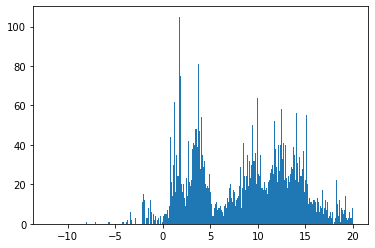

In [17]:
plt.hist(lista_pkaacid,bins=700)
plt.show()

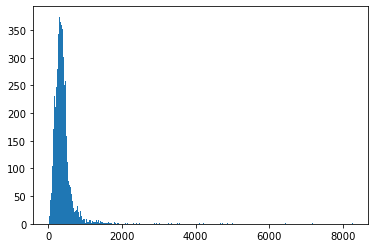

In [18]:
plt.hist(lista_mw,bins=700)
plt.show()

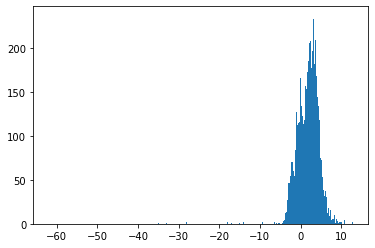

In [19]:
plt.hist(lista_lp, bins= 700)
plt.show()

Transformando o tipo de dado das colunas com valores numericos em float para poder fazer analise estatistica

In [20]:
cols = ['molecular_weight','logP','logS','pKa_Acid','pKa_Basic','physiological_charge',
'polar_surface_area','hydrogen_acceptor_count','hydrogen_donor_count','rotable_bond_count',
'refractivity','polarizability','number_of_rings','bioavailability']

for col in cols:
    drugbank_df[col] = drugbank_df[col].astype(np.float64)




In [21]:
drugbank_df['molecular_weight'].mean()

385.0411824650913

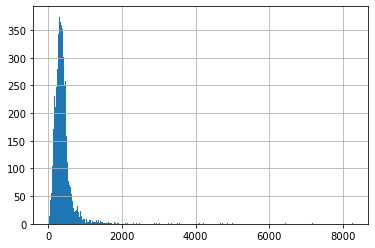

In [22]:
import math
drugbank_df['molecular_weight'].hist(bins = 700)

Dados estatisticos das colunas numericas transformadas para float

In [23]:
numerical_columns = drugbank_df.describe().columns
df_numerical = drugbank_df[numerical_columns]
drugbank_df.describe()

,molecular_weight,logP,logS,pKa_Acid,pKa_Basic,physiological_charge,polar_surface_area,hydrogen_acceptor_count,hydrogen_donor_count,rotable_bond_count,refractivity,polarizability,number_of_rings,bioavailability
count,11172.000000,11170.000000,10758.000000,9404.000000,10362.000000,10758.000000,11173.000000,11173.000000,11173.000000,11173.000000,11173.000000,11169.000000,11173.000000,11173.000000
mean,385.041182,1.812489,-3.381529,8.462630,2.688221,-3.381529,103.252947,5.375996,2.663295,6.352278,99.349198,38.350913,2.660073,0.848564
std,316.550921,2.650778,1.736293,5.428678,5.742671,1.736293,126.138432,6.054114,4.070047,8.888413,78.738375,30.736014,2.236808,0.358490
min,3.016000,-62.000000,-9.400000,-12.000000,-10.000000,-9.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.440000,0.000000,0.000000
25%,246.253925,0.112500,-4.600000,3.510000,-2.900000,-4.600000,53.070000,3.000000,1.000000,3.000000,61.880000,23.660000,1.000000,1.000000
50%,342.924500,2.070000,-3.600000,9.200000,3.090000,-3.600000,83.120000,4.000000,2.000000,5.000000,91.580000,35.100000,3.000000,1.000000
75%,443.977000,3.540000,-2.200000,12.700000,8.350000,-2.200000,116.450000,6.000000,3.000000,8.000000,117.960000,45.140000,4.000000,1.000000
max,8272.338000,12.870000,1.200000,20.000000,21.850000,1.200000,3617.470000,191.000000,116.000000,176.000000,1931.710000,735.410000,69.000000,1.000000


In [24]:
drugbank_df.mode(numeric_only=True)

,molecular_weight,logP,logS,pKa_Acid,pKa_Basic,physiological_charge,polar_surface_area,hydrogen_acceptor_count,hydrogen_donor_count,rotable_bond_count,refractivity,polarizability,number_of_rings,bioavailability
0,180.1559,-1.4,-3.8,3.09,-3.0,-3.8,0.0,4.0,1.0,4.0,0.0,1.78,3.0,1.0


In [ ]:
mw_df = drugbank_df['molecular_weight']
mw_df = pd.DataFrame(drugbank_df['molecular_weight'])
numeric_column = mw_df.describe().columns
mw_df = mw_df[numeric_column]
mw_df.describe()